# Detailed Earthquake Catalog for the San Jacinto Fault-Zone Region (WHITE) [1]

\cite{white2019detailed} created an enhanced catalog focusing on the San Jacinto fault region, using an dense seismic network in Southern California. This denser network, combined with automated phase picking (STA/LTA), ensures a 99\% detection rate for earthquakes greater than Mw 0.6 in a specific subregion [1].

## Downloading the dataset

We begin by importing the neccessary dependencies

In [2]:
import pandas as pd
import numpy as np
import urllib.request
import shutil
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
from scipy.ndimage import uniform_filter1d
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')
from plot_utils import download_file, extract_zip, maxc, azimuthal_equidistant_projection
from scipy.stats import linregress

# Custom Colormap
colors = ["#5F0F40", "#C9DAEA", "#84A07C", "#E36414", "#39A9DB", "#0081A7", "#284B63", "#FFD449"]

The dataset can be downloaded from https://data.mendeley.com/datasets/7ywkdx7c62/1 

In [2]:
# Define the URL and the local filename
url="https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/7ywkdx7c62-1.zip"
local_filename = "WHITE.zip"
extract_path = "./raw"

# Download and extract the file
download_file(url, local_filename)
extract_zip(local_filename, extract_path)

Downloaded WHITE.zip
Extracted to ./raw


In [3]:
raw_catalog = pd.read_csv("raw/events.csv", delim_whitespace=True)
# correcting a misslabeling of columns
raw_catalog.rename(columns={'time': 'magnitude', 'Ml': 'time'}, inplace=True)
raw_catalog['time'] = pd.to_datetime(raw_catalog['time'])
raw_catalog = raw_catalog.sort_values(by='time')
raw_catalog = raw_catalog[["time", "longitude", "latitude","magnitude"]].dropna()
raw_catalog.reset_index(drop=False, inplace=True)
raw_catalog.rename(columns={'index': 'id'}, inplace=True)
print('the raw catalog has', len(raw_catalog),'events')

251725


,id,time,longitude,latitude,magnitude
0,0,2008-01-01 00:07:32.270,-116.640540,33.593590,0.22
1,1,2008-01-01 02:37:08.798,-116.729111,33.586163,0.57
2,2,2008-01-01 03:12:13.911,-116.526950,33.493550,0.34
3,3,2008-01-01 04:19:05.720,-116.355667,33.345688,0.72
4,4,2008-01-01 05:14:50.490,-116.663270,33.610800,-0.01


## Visualising the Catalog

Let's plot events in the raw catalog over time along with an estimate of the completeness using Maximum Curvature [2]. We can see that the completeness of the catalog is relatively stable across the time period.

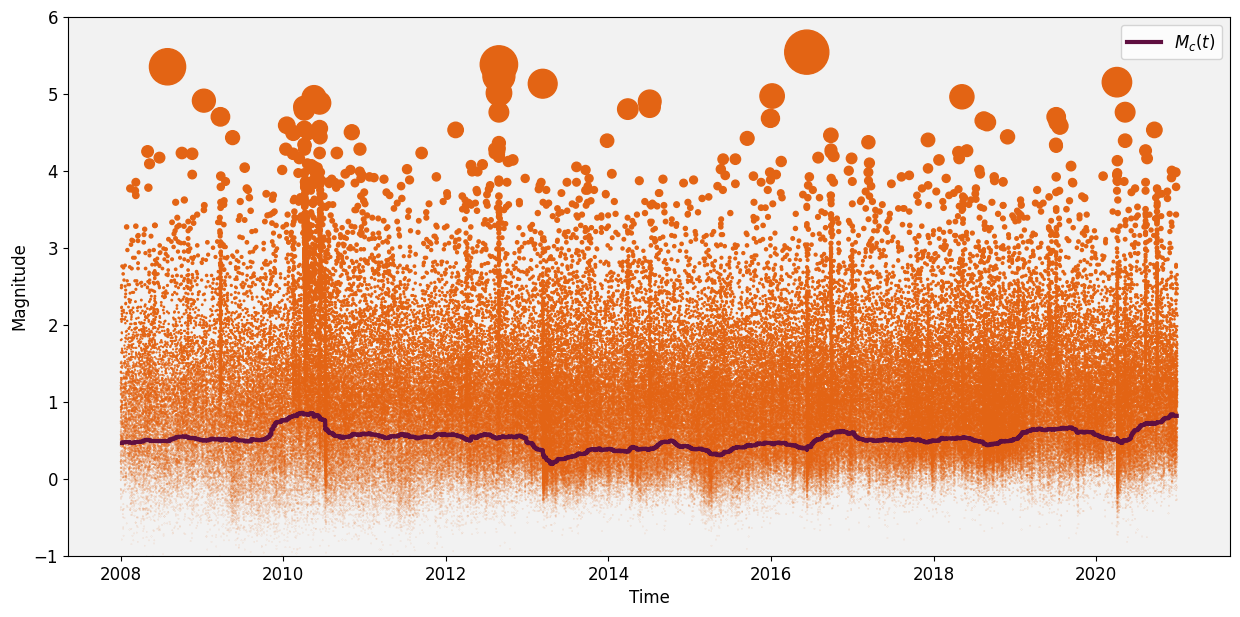

In [4]:
%matplotlib inline
plt.figure(figsize=(15, 7))
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Compute M_c(t) across the raw catalog
window_size=300
nwindows = math.floor(len(raw_catalog['magnitude'])/window_size)

Mc_t = [0]*nwindows
mid_time = [0]*nwindows

comp_T = raw_catalog['time']
comp_M = raw_catalog['magnitude']

for i in range(nwindows):
    
    mid_time[i] =  pd.Timestamp(pd.Series(comp_T[i*window_size:(i+1)*window_size]).mean())

    window = comp_M[i*window_size:(i+1)*window_size]
    Mc_t[i] = maxc(window,0.05)

# Smooth M_c(t) for plotting
Mc_t = uniform_filter1d(Mc_t, size=40)

# Plotting
plt.step(mid_time,Mc_t,colors[0],label=r'$M_c(t)$',lw=3)
# z = (9.5**raw_catalog['magnitude'])*0.0001
z = (8**raw_catalog['magnitude'])*0.01
plt.scatter(raw_catalog['time'],raw_catalog['magnitude'],s=z,color =colors[3])
plt.xlabel('Time',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.ylim([-1,6])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

Let's now visualise the coordinates of the events in the catalog

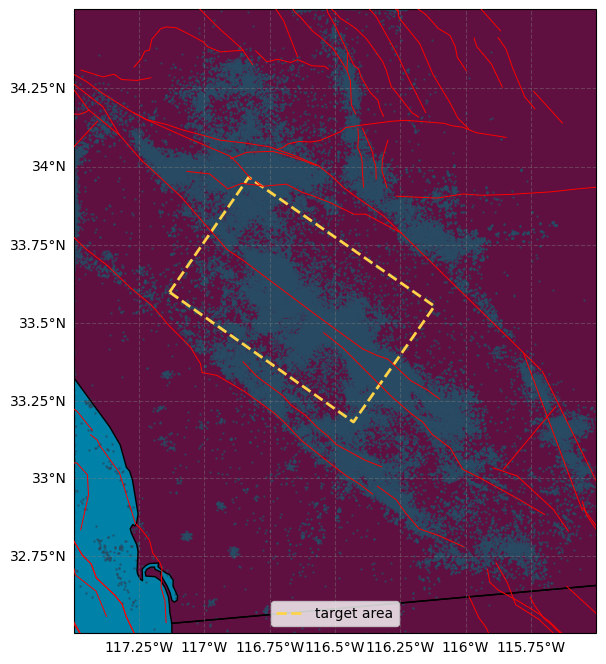

In [6]:
# Read the GEM fault data
gdf = gpd.read_file('/home/ss15859/Downloads/gem_active_faults.gpkg')
faults = gdf.geometry

# Filter the GeoDataFrame to include only geometries within the specified extent
max_lat, min_lat, max_lon, min_lon = 34.5, 32.5, -115.5, -117.5
filtered_gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

# Extract the geometry of the faults within the specified extent
faults_within_extent = filtered_gdf.geometry


# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-117.5, -115.5, 32.5, 34.5], crs=ccrs.PlateCarree())

# Add colored land and ocean
ax.add_feature(cfeature.LAND, facecolor="#5F0F40")
ax.add_feature(cfeature.OCEAN, facecolor="#0081A7")
ax.add_feature(cfeature.STATES, edgecolor='black')


# Plot the faults
for geom in faults_within_extent:
    ax.plot(geom.xy[0], geom.xy[1], color='red', transform=ccrs.PlateCarree(),zorder=10,linewidth=0.7)


# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Plot events
ax.scatter(raw_catalog['longitude'], raw_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[6], alpha=0.8)

# Plot polygon
polygon_coords = np.load('WHITE_shape.npy')
plot_polygon_coords = np.append(polygon_coords, [polygon_coords[0]], axis=0)
ax.plot(plot_polygon_coords[:, 1], plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color=colors[7], lw=2,linestyle='--',label='target area')
plt.legend()

plt.show()

## Truncating the Catalog

For this catalog, we follow [1] and keep events in the target area where the authors report a magnitude of completeness of 0.6.

Since the catalog's completeness is consistent across the time period, we don't need to truncate the catalog in time.

In [7]:
## filter events within polygon
poly = Polygon(polygon_coords)
gdf = gpd.GeoDataFrame(
    raw_catalog,
    geometry=gpd.points_from_xy(
        raw_catalog.latitude, raw_catalog.longitude),)

catalog = gdf[gdf.intersects(poly)].copy()
catalog.drop("geometry", axis=1, inplace=True)
len_trunc_x = len(catalog)
print('Removed',len(raw_catalog)-len_trunc_x, 'events outside polygon')

# filter events within timewindow
auxiliary_start = '2008-01-01 00:00:00'
test_nll_end = '2021-01-01 00:00:00'
catalog = catalog[catalog['time']>=auxiliary_start]
catalog = catalog[catalog['time']<test_nll_end]
len_trunc_t = len(catalog)
print('Removed',len_trunc_x-len_trunc_t, 'events outside timewindow')

Removed 88540 events outside polygon
Removed 0 events outside timewindow


We agree with the suggested magnitude of completeness (0.6) by [1]. A fit of the Gutenberg-Richter law appears to deviate from the magnitude frequency historgram around this point.

/tmp/ipykernel_299717/3084882788.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(bin_centers, 10**(slope * bin_centers + intercept), 'r-',color = colors[2], label='GR Fit',linewidth=linew)


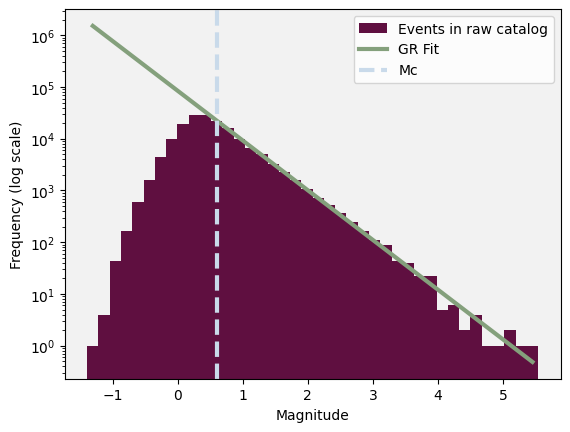

In [38]:
# plotting params
plt.figure()
plt.gca().set_facecolor((0.95, 0.95, 0.95))
bins = 40
linew = 3

# histogram
hist, bins = np.histogram(catalog['magnitude'], bins=bins)
log_hist = np.log10(hist[hist > 0])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers[hist > 0]

plt.hist(catalog['magnitude'], bins=bins, log=True, alpha=1, color=colors[0], label='Events in raw catalog')
plt.xlabel(r'Magnitude')
plt.ylabel('Frequency (log scale)')

# Fit a GR line to the log-transformed histogram data
mag_bin = 0.05
mask = (bin_centers >= 0.6) & (bin_centers<=7)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers[mask], log_hist[mask])
plt.plot(bin_centers, 10**(slope * bin_centers + intercept), 'r-',color = colors[2], label='GR Fit',linewidth=linew)
plt.axvline(x=0.6, color=colors[1], linestyle='--', label='Mc',linewidth=linew)

plt.legend()
plt.show()

Let's truncate the catalog above this threshold

In [8]:
# filter events above magnitude threshold
Mcut = 0.6
catalog = catalog[catalog['magnitude']>=Mcut]
len_trunc_m = len(catalog)
print('Removed',len_trunc_t-len_trunc_m, 'events below Mcut')

Removed 104549 events below Mcut


## The Processed Catalog

Let's now plot the truncated catalog, including the training, validation and testing windows. We can also label some of the major events that occurred.

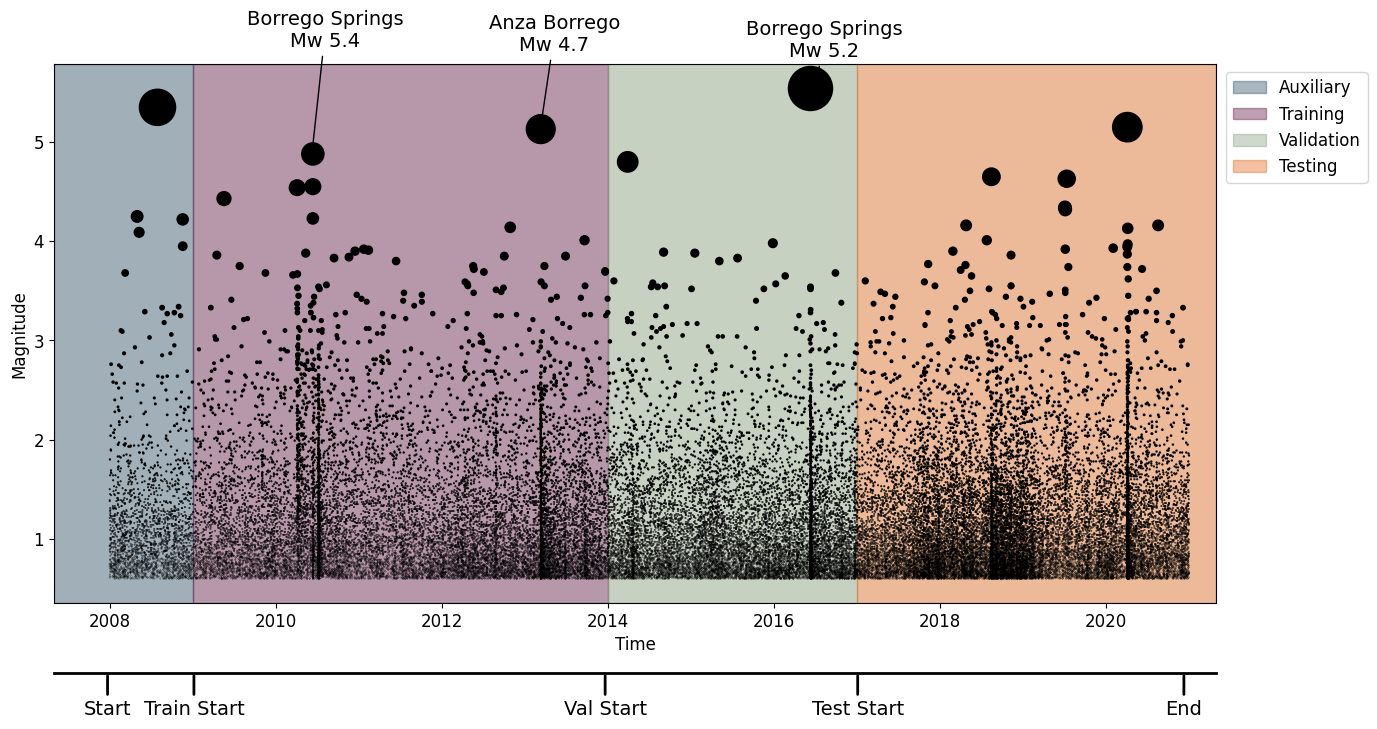

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# time windows for training, validation, and testing
auxiliary_start = pd.Timestamp('2008-01-01 00:00:00')
training_start = pd.Timestamp('2009-01-01 00:00:00')
validation_start = pd.Timestamp('2014-01-01 00:00:00')
testing_start = pd.Timestamp('2017-01-01 00:00:00')
testing_end = pd.Timestamp('2021-01-01 00:00:00')

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_facecolor((0.95, 0.95, 0.95))

# Plotting earthquakes
z = (8**catalog['magnitude'])*0.01
scatter = ax.scatter(catalog['time'], catalog['magnitude'], s=z, color='black')

xmin, xmax = pd.Timestamp('2007-05-01'), pd.Timestamp('2021-05-01')
ax.set_xlim(xmin, xmax)

# Highlighting time windows
alph = 0.4
ax.axvspan(xmin, training_start, color=colors[6], alpha=alph, label='Auxiliary', zorder=-100)
ax.axvspan(training_start, validation_start, color=colors[0], alpha=alph, label='Training', zorder=-100)
ax.axvspan(validation_start, testing_start, color=colors[2], alpha=alph, label='Validation', zorder=-100)
ax.axvspan(testing_start, xmax, color=colors[3], alpha=alph, label='Testing', zorder=-100)

trans = ax.get_xaxis_transform()
lineheight, textheight = -.13, -.18

# Annotations for train/val/test windows
annotations = [
    ('Start', 13870),
    ('Train Start', 14250),
    ('Val Start', 16059),
    ('Test Start', 17170),
    ('End', 18605),
]

for label, x_pos in annotations:
    ax.annotate(
        label, xy=(x_pos, lineheight), xycoords=trans, ha="center", va="top", fontsize=14,
        xytext=(x_pos, textheight), textcoords=trans, arrowprops=dict(arrowstyle='-', color='black', lw=2)
    )

ax.plot([xmin, xmax], [lineheight, lineheight], color="k", transform=trans, clip_on=False, lw=2)

# Event annotations
events = [
    ('2010-06-07', 'Borrego Springs','5.4','Mw'),
    ('2013-03-11', 'Anza Borrego','4.7','Ml' ),
    ('2016-06-10','Borrego Springs', '5.2','Mw' ),
]

ax.annotate(
        f'{events[0][1]}\n{events[0][3]} {events[0][2]}',
        xy=(pd.Timestamp(events[0][0]), float(events[0][2])-0.56),
        xytext=(10, 80),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=14,
        ha='center'
    )
ax.annotate(
        f'{events[1][1]}\n{events[0][3]} {events[1][2]}',
        xy=(pd.Timestamp(events[1][0]), float(events[1][2])+0.45),
        xytext=(10, 55),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=14,
        ha='center'
    )
ax.annotate(
        f'{events[2][1]}\n{events[0][3]} {events[2][2]}',
        xy=(pd.Timestamp(events[2][0]), float(events[2][2])+0.1),
        xytext=(10, 40),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=14,
        ha='center'
    )

# Labels and formatting
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.001, 1), fontsize=12)

plt.show()

Finally, since ETAS uses the great-circle distance between two points on a sphere (km), for the NPPs we need to project the coordinates of the events into a space such that inter-event distances are in km. To do this, we can use the Azimuthal equidistant projection [5], which preserves distances from all points to a center point.

We pass the mean coordinates of the catalog as the center coordinates of the projection.

In [10]:
center_latitude = catalog['latitude'].mean()  # Latitude of the center point
center_longitude = catalog['longitude'].mean()  # Longitude of the center point

# Convert latitude and longitude to Cartesian coordinates using Plate Carrée projection
catalog['x'], catalog['y'] = azimuthal_equidistant_projection(catalog['latitude'], catalog['longitude'], center_latitude, center_longitude)

Finally, we can write this pre-processed catalog to file.

In [11]:
catalog.to_csv("WHITE_catalog.csv", index=False)

## References

[1]: White, M. C., Ben‐Zion, Y., & Vernon, F. L. (2019). A detailed earthquake catalog for the San Jacinto fault‐zone region in southern California. Journal of Geophysical Research: Solid Earth, 124(7), 6908-6930.

[2]: Wiemer, S., & Wyss, M. (2000). Minimum magnitude of completeness in earthquake catalogs: Examples from Alaska, the western United States, and Japan. Bulletin of the Seismological Society of America, 90(4), 859-869.

[3]: Bradley, A. D. (1945). Azimuthal Equidistant Projection of the Sphere. The American Mathematical Monthly, 52(3), 148-151.